Importar Data

In [34]:
# Import your libraries:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import warnings

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings('ignore')

salesDF = pd.read_csv('../data/sales.csv', index_col=0)



Entender el dataset

In [35]:
# Análisis exploratorio inicial
print("Información básica del dataset:")
print("\nDimensiones del dataset:", salesDF.shape)
print("\nColumnas disponibles:")
print(salesDF.columns.tolist())

# Analizar tipos de datos y valores nulos
print("\nInformación de tipos de datos y valores nulos:")
print(salesDF.info())

# Estadísticas descriptivas básicas
print("\nEstadísticas descriptivas:")
print(salesDF.describe())

# Analizar valores únicos en columnas categóricas
print("\nValores únicos en columnas categóricas:")
for col in ['store_ID', 'day_of_week', 'open', 'date', 'promotion', 'state_holiday', 'school_holiday']:
    print(f"\n{col}:")
    print(salesDF[col].value_counts())


# Agregar detección de outliers
Q1 = salesDF['sales'].quantile(0.25)
Q3 = salesDF['sales'].quantile(0.75)
IQR = Q3 - Q1
outliers = salesDF[(salesDF['sales'] < (Q1 - 1.5 * IQR)) | (salesDF['sales'] > (Q3 + 1.5 * IQR))]
print("\nNúmero de outliers en ventas:", len(outliers))

Información básica del dataset:

Dimensiones del dataset: (640840, 9)

Columnas disponibles:
['store_ID', 'day_of_week', 'date', 'nb_customers_on_day', 'open', 'promotion', 'state_holiday', 'school_holiday', 'sales']

Información de tipos de datos y valores nulos:
<class 'pandas.core.frame.DataFrame'>
Index: 640840 entries, 425390 to 305711
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   store_ID             640840 non-null  int64 
 1   day_of_week          640840 non-null  int64 
 2   date                 640840 non-null  object
 3   nb_customers_on_day  640840 non-null  int64 
 4   open                 640840 non-null  int64 
 5   promotion            640840 non-null  int64 
 6   state_holiday        640840 non-null  object
 7   school_holiday       640840 non-null  int64 
 8   sales                640840 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 48.9+ MB
None

Estadísticas descr

Ver Matriz de correlacion

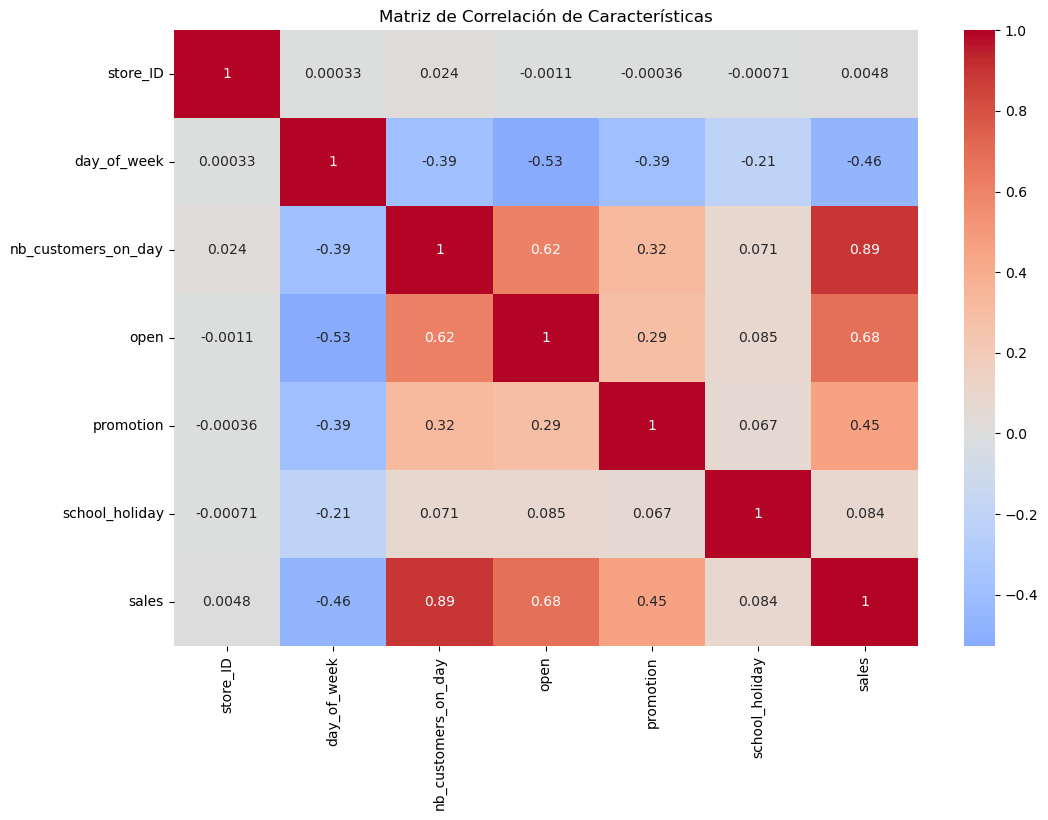

In [36]:
# Crear matriz de correlación usando columnas numéricas


# Crear matriz de correlación usando columnas numéricas
correlation_matrix = salesDF.select_dtypes(include=['int64', 'float64']).corr()

# Crear heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación de Características')
plt.show()


Eliminacion de valores faltantes

In [37]:
# Challenge 3 - Manejar Valores Faltantes

# Examinar valores faltantes
print("Número de valores faltantes por columna:")
print(salesDF.isnull().sum())

# Calcular porcentaje de valores faltantes
print("\nPorcentaje de valores faltantes por columna:")
print((salesDF.isnull().sum() / len(salesDF)) * 100)

# Eliminar columnas con más del 50% de valores faltantes
missing_percentages = (salesDF.isnull().sum() / len(salesDF)) * 100
columns_to_drop = missing_percentages[missing_percentages > 50].index
sales_cleaned = salesDF.drop(columns=columns_to_drop)

# Eliminar filas con valores faltantes
sales_cleaned = sales_cleaned.dropna()




Número de valores faltantes por columna:
store_ID               0
day_of_week            0
date                   0
nb_customers_on_day    0
open                   0
promotion              0
state_holiday          0
school_holiday         0
sales                  0
dtype: int64

Porcentaje de valores faltantes por columna:
store_ID               0.0
day_of_week            0.0
date                   0.0
nb_customers_on_day    0.0
open                   0.0
promotion              0.0
state_holiday          0.0
school_holiday         0.0
sales                  0.0
dtype: float64


Convertir fecha a timestamp int64

In [38]:

sales_cleaned['date'] = sales_cleaned['date'].str[5:7]
sales_cleaned['date']= sales_cleaned['date'].astype(int)

# Verificar el cambio de date
print("\nTipo de datos de la columna date después de la conversión:")
print(sales_cleaned['date'].dtype)


Tipo de datos de la columna date después de la conversión:
int64


Convertir state_holiday a int64

In [39]:
# Cambiar los valores de state_holiday
good_state_holiday = {
    '0': 0,  
    'a': 1,
    'b': 1,
    'c': 1
}

# Convertir state_holiday a números y asegurar tipo int64
sales_cleaned['state_holiday'] = sales_cleaned['state_holiday'].map(good_state_holiday).astype('int64')

# Verificar los cambios
print("\nTipo de datos de state_holiday después de la conversión:")
print(sales_cleaned['state_holiday'].dtype)

print("\nValores únicos en state_holiday:")
print(sales_cleaned['state_holiday'].value_counts())

print("\nInformación actualizada del DataFrame:")
print(sales_cleaned.info())




Tipo de datos de state_holiday después de la conversión:
int64

Valores únicos en state_holiday:
state_holiday
0    621160
1     19680
Name: count, dtype: int64

Información actualizada del DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 640840 entries, 425390 to 305711
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   store_ID             640840 non-null  int64
 1   day_of_week          640840 non-null  int64
 2   date                 640840 non-null  int64
 3   nb_customers_on_day  640840 non-null  int64
 4   open                 640840 non-null  int64
 5   promotion            640840 non-null  int64
 6   state_holiday        640840 non-null  int64
 7   school_holiday       640840 non-null  int64
 8   sales                640840 non-null  int64
dtypes: int64(9)
memory usage: 48.9 MB
None


Dividir datos para modelado

In [40]:
# Challenge 5 - Modelado y Predicción 


# Preparar variables para predecir 'sales'
X = sales_cleaned.drop(['sales'], axis=1)  # Quitamos la columna objetivo
y = sales_cleaned['sales']  # Variable objetivo

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

LINEAR REGRESSION

In [41]:
# Importar bibliotecas necesarias


# Crear y entrenar el modelo de regresión lineal
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# Generar predicciones para entrenamiento y prueba
y_pred_train = modelo.predict(X_train)
y_pred_test = modelo.predict(X_test)

# Calcular métricas de evaluación
metricas = {
    'R² Entrenamiento': r2_score(y_train, y_pred_train),
    'R² Prueba': r2_score(y_test, y_pred_test),
    'MSE Entrenamiento': mean_squared_error(y_train, y_pred_train),
    'MSE Prueba': mean_squared_error(y_test, y_pred_test),
    'RMSE Entrenamiento': mean_squared_error(y_train, y_pred_train, squared=False),
    'RMSE Prueba': mean_squared_error(y_test, y_pred_test, squared=False),
    'MAE Entrenamiento': mean_absolute_error(y_train, y_pred_train),
    'MAE Prueba': mean_absolute_error(y_test, y_pred_test)
}

# Imprimir resultados
print("=== Resultados del Modelo de Regresión Lineal ===\n")

# Mostrar primeras predicciones
print("Primeras 5 predicciones vs valores reales (conjunto de entrenamiento):")
for pred, real in zip(y_pred_train[:5], y_train.iloc[:5]):
    print(f"Predicción: {pred:.2f} | Real: {real:.2f}")

print("\n=== Métricas de Evaluación ===")
for metrica, valor in metricas.items():
    print(f"{metrica}: {valor:.4f}")

# Calcular y mostrar importancia de características
importancia_caracteristicas = pd.DataFrame({
    'caracteristica': X.columns,
    'importancia': abs(modelo.coef_)
}).sort_values('importancia', ascending=False)

print("\n=== Importancia de Características ===")
print(importancia_caracteristicas)

=== Resultados del Modelo de Regresión Lineal ===

Primeras 5 predicciones vs valores reales (conjunto de entrenamiento):
Predicción: 7274.12 | Real: 7534.00
Predicción: 8567.06 | Real: 11018.00
Predicción: 8786.79 | Real: 7452.00
Predicción: 8993.82 | Real: 6938.00
Predicción: 4180.22 | Real: 4679.00

=== Métricas de Evaluación ===
R² Entrenamiento: 0.8541
R² Prueba: 0.8515
MSE Entrenamiento: 2165251.3216
MSE Prueba: 2195060.5697
RMSE Entrenamiento: 1471.4793
RMSE Prueba: 1481.5737
MAE Entrenamiento: 985.1332
MAE Prueba: 985.8441

=== Importancia de Características ===
        caracteristica  importancia
4                 open  1487.139348
5            promotion  1288.679784
6        state_holiday   765.213908
1          day_of_week    77.502737
7       school_holiday    39.827888
2                 date    25.331858
3  nb_customers_on_day     6.062768
0             store_ID     0.144597


XGBOOST



=== Análisis de Importancia de Features con XGBoost ===

--- XGBoost ---

Resultados XGBoost:
R2 Score: 0.1639
MSE: 12359658.9980


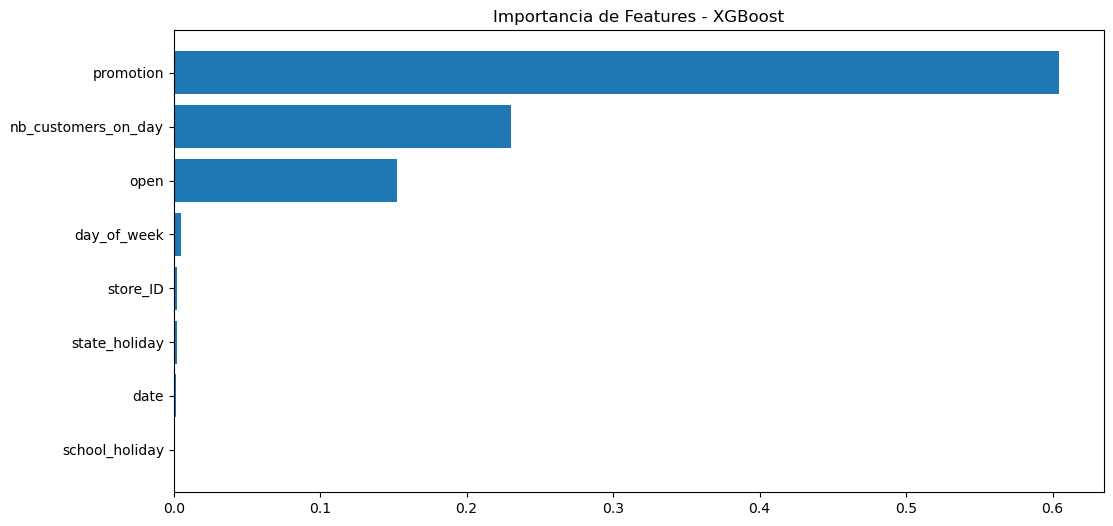

In [45]:
# Importar las librerías necesarias


print("\n=== Análisis de Importancia de Features con XGBoost ===")

# XGBoost
print("\n--- XGBoost ---")
# Definir parámetros de XGBoost para regresión
params_xgb = {
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 15,
    'random_state': 42
}

# Instanciar y entrenar modelo XGBoost
model_xgb = xgb.XGBRegressor(**params_xgb)
model_xgb.fit(X_train, y_train)

# Hacer predicciones
y_pred_xgb = model_xgb.predict(X_test)

# Evaluar modelo
print("\nResultados XGBoost:")
print(f"R2 Score: {r2_score(y_test, y_pred_xgb):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_xgb):.4f}")

# Visualizar importancia de features con XGBoost
plt.figure(figsize=(12, 6))
sorted_idx = model_xgb.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], model_xgb.feature_importances_[sorted_idx])
plt.title('Importancia de Features - XGBoost')
plt.show()

Random Forest


--- Random Forest ---

Resultados Random Forest:
R2 Score: 0.8183
MSE: 2686211.6161


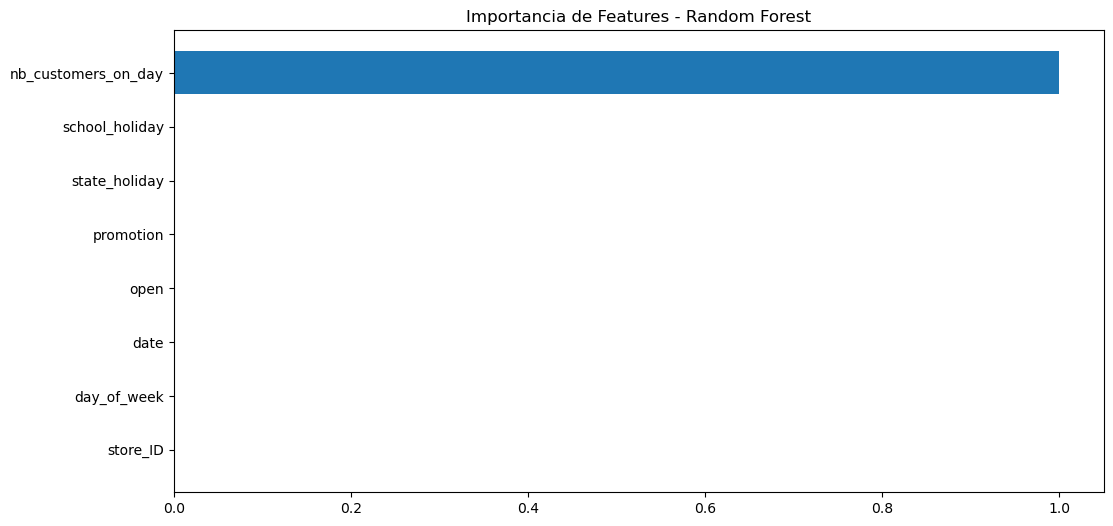

In [43]:
# Importar Random Forest


# Random Forest
print("\n--- Random Forest ---")
# Definir parámetros de Random Forest
params_rf = {
    'n_estimators': 100,
    'max_depth': 3,
    'random_state': 42
}

# Instanciar y entrenar modelo Random Forest
model_rf = RandomForestRegressor(**params_rf)
model_rf.fit(X_train, y_train)

# Hacer predicciones
y_pred_rf = model_rf.predict(X_test)

# Evaluar modelo
print("\nResultados Random Forest:")
print(f"R2 Score: {r2_score(y_test, y_pred_rf):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_rf):.4f}")

# Visualizar importancia de features con Random Forest
plt.figure(figsize=(12, 6))
sorted_idx = model_rf.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], model_rf.feature_importances_[sorted_idx])
plt.title('Importancia de Features - Random Forest')
plt.show()

Comparacion de modelos


=== Comparación de Modelos ===

Regresión Lineal:
R2 Score: 0.8515
MSE: 2195060.5697

XGBoost:
R2 Score: 0.9359
MSE: 947044.2395

Random Forest:
R2 Score: 0.8183
MSE: 2686211.6161


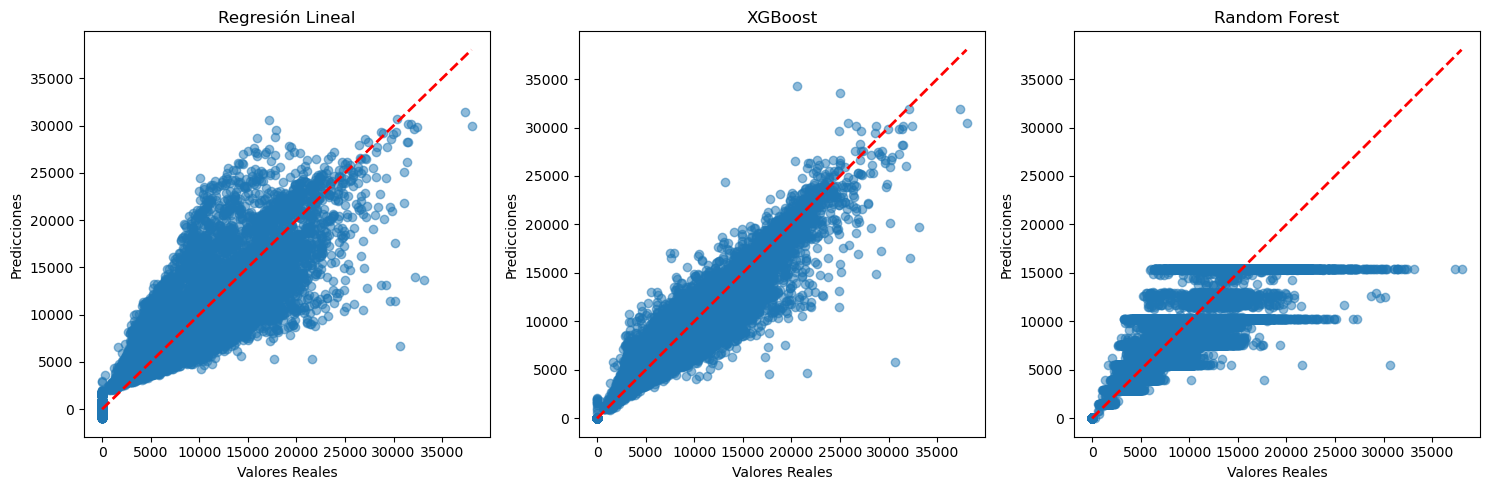

In [44]:
# Comparación de modelos
print("\n=== Comparación de Modelos ===")
modelos = {
    'Regresión Lineal': (modelo, y_pred_test),
    'XGBoost': (model_xgb, y_pred_xgb),
    'Random Forest': (model_rf, y_pred_rf)
}

for nombre, (modelo, predicciones) in modelos.items():
    print(f"\n{nombre}:")
    print(f"R2 Score: {r2_score(y_test, predicciones):.4f}")
    print(f"MSE: {mean_squared_error(y_test, predicciones):.4f}")

# Visualización comparativa de predicciones
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Regresión Lineal')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')

plt.subplot(132)
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('XGBoost')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')

plt.subplot(133)
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Random Forest')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')

plt.tight_layout()
plt.show()